## Backtesting 
### Métricas (2)
En este cuaderno continuamos con el cáclulo de métricas, pero introducimos
- el uso de reglas de trading que aplicamos a varios activos a la vez
- la comparación respecto al índice de referencia

De momento esta comparación no es justa porque no tenemos una correspondencia con el universo de acciones invertibles

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import itertools

### Datos 
Asumiremos por un tema se simplicidad en los ejemplos, que nuestro universo de acciones invertibles son las siguientes acciones del IBEX35.

In [2]:
ticker_list = ['BBVA','SAN','REP','TEF','IBE','FER','ITX','ACS','GRF']

In [3]:
import pickle
with open('../data/stock_data.pkl', 'rb') as handle:
    stock_data = pickle.load(handle)

In [4]:
close_series = {ticker: df.close for ticker, df in stock_data.items()
                if ticker in ticker_list}
stock_df = pd.DataFrame(close_series)
stock_df = stock_df.loc['2010':]

In [5]:
stock_df.head()

,SAN,FER,ACS,ITX,BBVA,IBE,REP,GRF,TEF
2010-01-04,5.665913,4.830823,19.599646,7.094121,6.763884,3.695395,8.393345,4.829916,10.444406
2010-01-05,5.728703,4.894763,19.944224,7.047400,6.810948,3.699710,8.417832,4.764089,10.428564
2010-01-06,5.769572,5.056533,19.985099,7.050594,6.837040,3.694835,8.379870,4.738822,10.352160
2010-01-07,5.743318,5.030070,19.785465,6.947297,6.805664,3.671260,8.384384,4.697976,10.249353
2010-01-08,5.762265,5.046118,20.217352,6.971478,6.857930,3.667345,8.375356,4.628159,10.070059


Eliminaremos primero las acciones que no han estado en el índice durante todo el periodo de evaluación

In [6]:
stock_df.dropna(axis=1, how='all', inplace=True)
stock_df

,SAN,FER,ACS,ITX,BBVA,IBE,REP,GRF,TEF
2010-01-04,5.665913,4.830823,19.599646,7.094121,6.763884,3.695395,8.393345,4.829916,10.444406
2010-01-05,5.728703,4.894763,19.944224,7.047400,6.810948,3.699710,8.417832,4.764089,10.428564
2010-01-06,5.769572,5.056533,19.985099,7.050594,6.837040,3.694835,8.379870,4.738822,10.352160
2010-01-07,5.743318,5.030070,19.785465,6.947297,6.805664,3.671260,8.384384,4.697976,10.249353
2010-01-08,5.762265,5.046118,20.217352,6.971478,6.857930,3.667345,8.375356,4.628159,10.070059
...,...,...,...,...,...,...,...,...,...
2020-08-17,1.890800,22.610000,21.160000,23.700000,2.515000,10.925000,6.842000,24.720000,3.580000
2020-08-18,1.877000,22.830000,21.150000,23.290000,2.478000,10.805000,6.756000,24.320000,3.525000
2020-08-19,1.934200,23.130000,21.710000,23.270000,2.553000,10.825000,6.820000,23.700000,3.610000
2020-08-20,1.853800,22.750000,21.340000,22.950000,2.464000,10.795000,6.692000,23.580000,3.512000


También usaremos el **benchmark**, la  serie del ibex con dividendos

In [7]:
with open('../data/benchmark.pkl', 'rb') as handle:
    benchmarks = pickle.load(handle)

In [8]:
benchmarks.keys()

dict_keys(['ibex', 'ibex_div'])

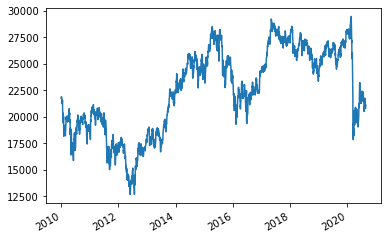

In [9]:
benchmark = benchmarks['ibex_div'].close.loc['2010':]
benchmark.plot()

____
### Estrategia Media Móvil
Implementamos una estrategia de buscar las tendencias alcistas cuando
el precio esté por encima de la media móvil. La idea es tener una estrategia
sencilla independiente por cada acción

In [10]:
def movaverage_states(vseries, win):
    sma = vseries.rolling(win).mean()
    signal_states = (vseries > sma).astype(float)
    trading_states = signal_states.shift(1)
    trading_states.iloc[0] = 0
    return trading_states

In [11]:
def plot_sma_states(vseries, win):
    sma = vseries.rolling(win).mean()
    states = movaverage_states(vseries, win)
  
    fig, ax = plt.subplots(figsize=(20,4))
    vseries.plot(ax=ax)
    sma.plot(ax=ax)

    for i, idx in enumerate(states.index[:-1]):
        if states.loc[idx] == 1:
            ax.axvspan(idx, states.index[i+1], facecolor='g', alpha=0.2)

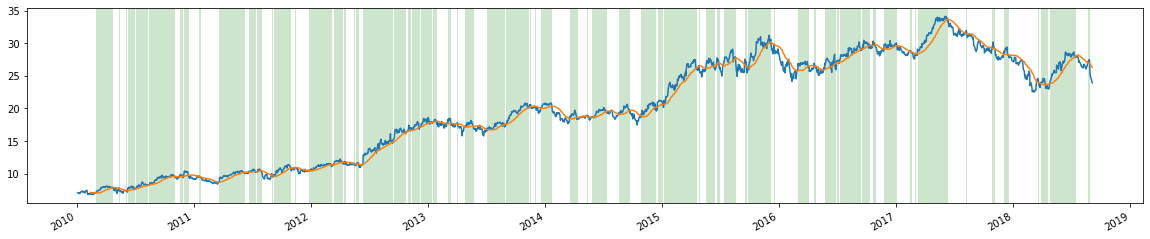

In [12]:
plot_sma_states(stock_df['ITX'].iloc[:-500], 30)

In [13]:
def state_return_serie(price, states):
    """ 
    """
    real_serie = price.dropna()
    ret = real_serie.pct_change()
    ret.iloc[0] = 0
    ret_series = ret * states
    return ret_series
    

___

In [14]:
stock_states = stock_df.apply(movaverage_states, win=50)
stock_states

,SAN,FER,ACS,ITX,BBVA,IBE,REP,GRF,TEF
2010-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2020-08-17,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2020-08-18,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2020-08-19,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2020-08-20,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [15]:
example_returns = state_return_serie(stock_df['FER'], stock_states['FER'])
example_returns

2010-01-04    0.0
2010-01-05    0.0
2010-01-06    0.0
2010-01-07   -0.0
2010-01-08    0.0
             ... 
2020-08-17    0.0
2020-08-18    0.0
2020-08-19    0.0
2020-08-20   -0.0
2020-08-21    0.0
Name: FER, Length: 2721, dtype: float64

solo tenemos fluctuación de retorno cuando estamos invertidos

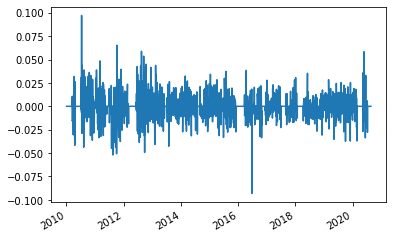

In [16]:
example_returns.plot()

____
Calculamos la serie de rendimientos a partir de los estados, para todas las acciones

In [17]:
sma_returns = [state_return_serie(stock_df[tk], stock_states[tk]) for tk in stock_df.columns]
sma_returns_df = pd.concat(sma_returns, axis=1)
sma_returns_df

,SAN,FER,ACS,ITX,BBVA,IBE,REP,GRF,TEF
2010-01-04,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0
2010-01-05,0.0,0.0,0.0,-0.0000,0.0,0.000000,0.0,-0.0,-0.0
2010-01-06,0.0,0.0,0.0,0.0000,0.0,-0.000000,-0.0,-0.0,-0.0
2010-01-07,-0.0,-0.0,-0.0,-0.0000,-0.0,-0.000000,0.0,-0.0,-0.0
2010-01-08,0.0,0.0,0.0,0.0000,0.0,-0.000000,-0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...
2020-08-17,-0.0,0.0,-0.0,0.0000,-0.0,-0.004102,-0.0,0.0,-0.0
2020-08-18,-0.0,0.0,-0.0,-0.0173,-0.0,-0.010984,-0.0,-0.0,-0.0
2020-08-19,0.0,0.0,0.0,-0.0000,0.0,0.001851,0.0,-0.0,0.0
2020-08-20,-0.0,-0.0,-0.0,-0.0000,-0.0,-0.002771,-0.0,-0.0,-0.0


In [18]:
sma_performance = (sma_returns_df + 1).cumprod()
sma_performance

,SAN,FER,ACS,ITX,BBVA,IBE,REP,GRF,TEF
2010-01-04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2010-01-05,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2010-01-06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2010-01-07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2010-01-08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...
2020-08-17,0.269925,2.184602,1.243932,1.211504,0.639316,1.812798,0.856513,2.639011,0.507792
2020-08-18,0.269925,2.184602,1.243932,1.190545,0.639316,1.792886,0.856513,2.639011,0.507792
2020-08-19,0.269925,2.184602,1.243932,1.190545,0.639316,1.796205,0.856513,2.639011,0.507792
2020-08-20,0.269925,2.184602,1.243932,1.190545,0.639316,1.791227,0.856513,2.639011,0.507792


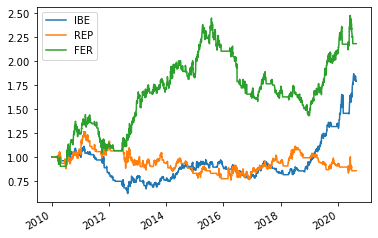

In [19]:
sma_performance[['IBE','REP','FER']].plot()

___

### Calculo agregado de rentabilidad
Si hacemos esta estrategia equiponderada tendriamos que dividir el resultado
entre todos los elementos que se encuentren en el índice ese día 

In [20]:
sma_performance.iloc[0].dropna().count()

9

In [21]:
def equiperformance(performance_row):
    n = performance_row.dropna().count()
    return performance_row/n

In [22]:
equiperformance(sma_performance.iloc[0])

SAN     0.111111
FER     0.111111
ACS     0.111111
ITX     0.111111
BBVA    0.111111
IBE     0.111111
REP     0.111111
GRF     0.111111
TEF     0.111111
Name: 2010-01-04 00:00:00, dtype: float64

In [23]:
equity_performance = sma_performance.apply(equiperformance, axis=1)
equity_performance

,SAN,FER,ACS,ITX,BBVA,IBE,REP,GRF,TEF
2010-01-04,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
2010-01-05,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
2010-01-06,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
2010-01-07,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
2010-01-08,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
...,...,...,...,...,...,...,...,...,...
2020-08-17,0.029992,0.242734,0.138215,0.134612,0.071035,0.201422,0.095168,0.293223,0.056421
2020-08-18,0.029992,0.242734,0.138215,0.132283,0.071035,0.199210,0.095168,0.293223,0.056421
2020-08-19,0.029992,0.242734,0.138215,0.132283,0.071035,0.199578,0.095168,0.293223,0.056421
2020-08-20,0.029992,0.242734,0.138215,0.132283,0.071035,0.199025,0.095168,0.293223,0.056421


En realidad el rendimiento es el mismo, solo que aportará la parte proporcional al portfolio

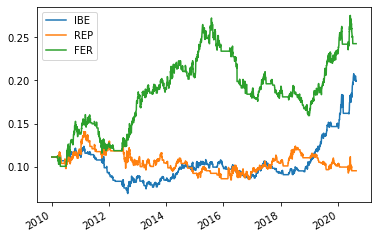

In [24]:
equity_performance[['IBE','REP','FER']].plot()

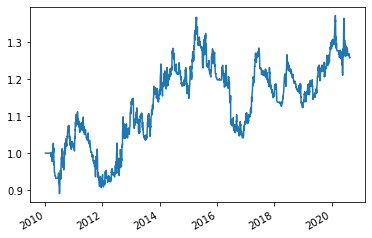

In [25]:
porfolio_performance = equity_performance.sum(axis=1)
porfolio_performance.plot()

### Comparación con el Benchmark

In [26]:
relative_bm = benchmark/benchmark.iloc[0]

In [27]:
estrategias = pd.DataFrame({
    'SMA': porfolio_performance,
    'Ibexdiv': relative_bm

})

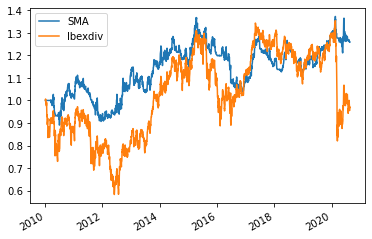

In [28]:
estrategias.plot()

### Métricas respecto al Benchmark

Primero el **periodo de tiempo** de la evaluación

In [29]:
init_date, end_date = relative_bm.index[0], relative_bm.index[-1]
years_in = (end_date - init_date) / pd.Timedelta(days=365, hours=6)
years_in

10.628336755646817

In [30]:
bdays_year = int(relative_bm.shape[0]/years_in)
bdays_year

256

**Rendimiento Anualizado** 


In [31]:
portval = porfolio_performance

In [32]:
port_total_ret = portval.iloc[-1]/portval.iloc[0] - 1
port_total_ret

0.25846457926207145

In [33]:
ann_ret = np.power(port_total_ret + 1, 1/years_in) - 1
ann_ret

0.02186576518037131

**Active_return**

In [34]:
bench_ret = relative_bm.iloc[-1]/relative_bm.iloc[0] - 1
bench_annret = np.power(bench_ret + 1, 1/years_in) - 1
bench_annret

-0.004105979438916996

In [35]:
active_ret = ann_ret - bench_annret
active_ret

0.025971744619288306

**Information Ratio**

In [36]:
logret = np.log(portval).diff().dropna()
bench_logret = np.log(relative_bm).diff().dropna()

In [37]:
active_dayret = logret - bench_logret
active_dayret.head()

2010-01-05   -0.004874
2010-01-06   -0.001482
2010-01-07    0.004609
2010-01-08   -0.000032
2010-01-11    0.007305
dtype: float64

In [38]:
tracking_error = np.sqrt(bdays_year) * active_dayret.std()
inform_ratio = (bdays_year * active_dayret.mean()) / tracking_error
inform_ratio

0.14409802845825428

___